In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imagecodecs

     |████████████████████████████████| 24.7MB 160kB/s 


**SET UP**

Let's start by importing the libraries we need to load and visualize the data.

We need the following libraries:

*   Pandas: Read and write comma-seperated value (csv) files
*   Numpy: Numerical Computations
*   SKImage: Read images
*   Matplotlib: Visualize Images

Also we need *imagecodecs* to properly read *.tif* spectral band images using skimage.



```
pip install imagecodecs
```





In [3]:
import os

import pandas as pd
import numpy as np

import skimage.io
import matplotlib.pylab as plt

We can now start loading the data. The data consists of satellite images of agricultural fields along with meta-data files.

The main meta-data files are *train.csv* for the training images and *test.csv* for the test images.

Let's start with the training data.

In [4]:
train = pd.read_csv('drive/MyDrive/data/train.csv')

There are 2 types of satellite images provided in this competition:


*   RGB color images taken at June'17, December'17, June'18, and December'18
*   Spectral band images from the Sentinel-2 satellite taken monthly over the entire year of the data point acquisition i.e. the *Year* column in the meta-data.

More details of these images can be found in the data description page. 



In [5]:
print("Contents of June'17 data", os.listdir('drive/MyDrive/data/planet-jun17')[:5], "...")
print("Contents of December'17 data", os.listdir('drive/MyDrive/data/planet-dec17')[:5], "...")
print("Contents of June'18 data", os.listdir('drive/MyDrive/data/planet-jun18')[:5], "...")
print("Contents of December'18 data", os.listdir('drive/MyDrive/data/planet-dec18')[:5], "...")
print("Contents of Sentinel data", os.listdir('drive/MyDrive/data/sentinel')[:5], "...")

Contents of June'17 data ['bf2eb31d.png', 'f3299b09.png', '1a19fd51.png', '0537dfba.png', '2248aa77.png'] ...
Contents of December'17 data ['bf2eb31d.png', 'f3299b09.png', '1a19fd51.png', '0537dfba.png', '2248aa77.png'] ...
Contents of June'18 data ['bf2eb31d.png', 'f3299b09.png', '1a19fd51.png', '0537dfba.png', '2248aa77.png'] ...
Contents of December'18 data ['bf2eb31d.png', 'f3299b09.png', '1a19fd51.png', '0537dfba.png', '2248aa77.png'] ...
Contents of Sentinel data ['327867d7.tif', '755931c0.tif', 'e42f0423.tif', '8755e5ca.tif', 'ab010453.tif'] ...


**DATA EXPLORATION**

We now try to do understand our data.

Let's start with the meta-data.

In [6]:
print("Train meta-data shape:", train.shape)
train.head(5)

Train meta-data shape: (410, 7)


,ID,Year,PlotSize_acres,Yield,Quality,x,y
0,id_ade6610c,2018,0.25,NaN,2,-0.100546,0.131002
1,id_c987f14e,2018,2.00,NaN,1,-0.985732,-0.032197
2,id_92e2cdbf,2016,1.00,0.37125,1,-1.335971,-1.069998
3,id_a1ce519e,2017,1.50,0.26875,3,0.000000,0.000000
4,id_66ea43d6,2017,1.50,0.26875,3,0.000000,0.000000


In [7]:
train.Year.value_counts()

2018    171
2015    118
2017     62
2016     59
Name: Year, dtype: int64

In [8]:
train.Quality.value_counts()

1    179
3    127
2    104
Name: Quality, dtype: int64

We can see that we have data points from 2015 to 2018. We have the most data points from 2018 and the least from 2016.

The Quality column describes the confidence of the annotator in the label, with *1* being least confident and *3* being most confident.

Let's statistically summarize the remaining columns grouped by each year.

In [9]:
train.drop('Quality', 1).groupby("Year").describe(percentiles=[])

PlotSize_acres                      ...         y                    
              count      mean       std  ...       min       50%       max
Year                                     ...                              
2015          118.0  0.754174  0.675112  ... -1.310685  0.000000  0.743430
2016           59.0  0.483051  0.307466  ... -1.069998  0.000000  0.562121
2017           62.0  0.537903  0.355194  ... -0.621791  0.000000  0.713488
2018          171.0  0.731231  0.704576  ... -1.203995  0.015263  1.176673

[4 rows x 24 columns]

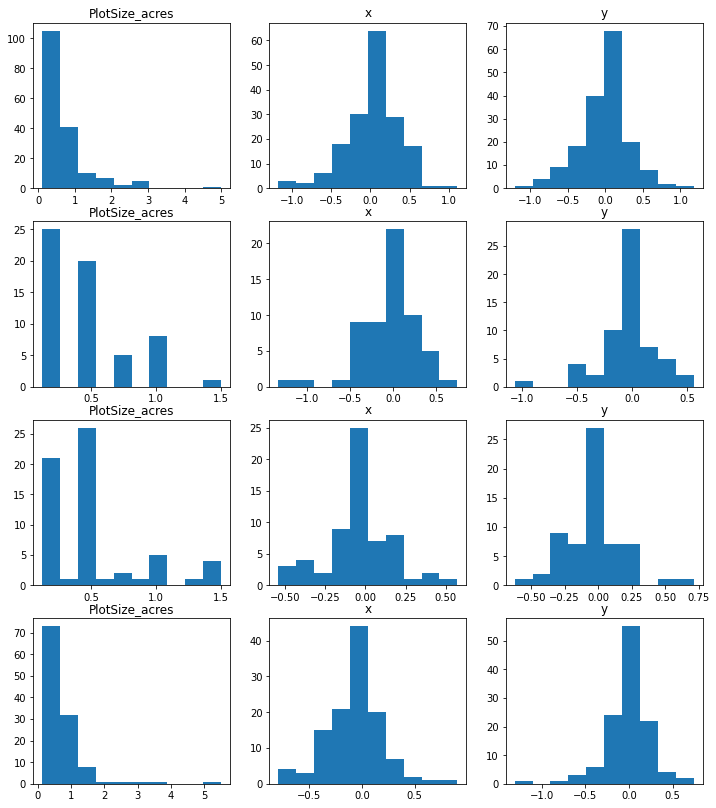

In [10]:
fig, ax = plt.subplots(len(train.Year.unique()), 3, figsize=(12,14))
for i, year in enumerate(train.Year.unique()):
  ax[i][0].hist(train[train.Year == year].PlotSize_acres)
  ax[i][0].set_title('PlotSize_acres')
  ax[i][1].hist(train[train.Year == year].x)
  ax[i][1].set_title('x')
  ax[i][2].hist(train[train.Year == year].y)
  ax[i][2].set_title('y')
plt.show()

Now let's visualize the images.

We need two constant value to map the (x,y) values into the pixel-space of the image.

In [11]:
CONST_X = 10.986328125 / 2
CONST_Y = 10.985731758 / 2

We can sample a random row from the data.

In [12]:
row = train.sample()
row

,ID,Year,PlotSize_acres,Yield,Quality,x,y
108,id_21307082,2015,0.25,0.39125,2,-0.023382,0.261197


We now read the RGB images for each of the 4 image dates June'17, December'17, June'18, and December'18.

In [13]:
def load_RGB_images(ID):
  # e.g id_0b242e06 -> 0b242e06
  name = ID.split('_')[1]
  img_jun17 = skimage.io.imread(f'drive/MyDrive/data/planet-jun17/{name}.png')
  img_dec17 = skimage.io.imread(f'drive/MyDrive/data/planet-dec17/{name}.png')
  img_jun18 = skimage.io.imread(f'drive/MyDrive/data/planet-jun18/{name}.png')
  img_dec18 = skimage.io.imread(f'drive/MyDrive/data/planet-dec18/{name}.png')
  return img_jun17, img_dec17, img_jun18, img_dec18

In [14]:
img_jun17, img_dec17, img_jun18, img_dec18 = load_RGB_images(row.ID.values[0])

Note that the image size can slightly vary e.g. 84x84 or 83x83.

It is important to account for this difference in your preprocessing code when training a model e.g. padding with zeros.

In [15]:
img_jun17.shape

(84, 83, 3)

Let's inspect one of these images.

We can visualize it.

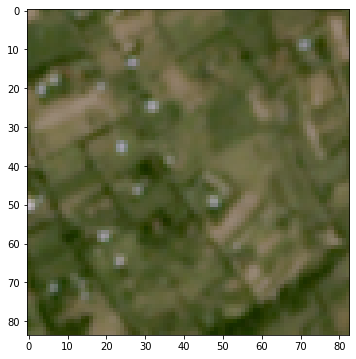

In [16]:
fig = plt.figure(figsize=(6,6))
plt.imshow(img_jun17)
plt.show()

OK, now let's visualize the actual (x, y) markers on the image.

The center of the image is the desired point we wish to fix and the (x, y) point is the annotated label of the difference between the original point (center) and the correct coordinates.


In [17]:
x0, y0 = img_jun17.shape[0]//2, img_jun17.shape[1]//2
x1 = x0 - np.round(row.x.values[0] / CONST_X * img_jun17.shape[0])
y1 = y0 + np.round(row.y.values[0] / CONST_Y * img_jun17.shape[1])

Now we have the fixed coordinates (x1, y1) and we can visualize them.

Let's visualize all 4 RGB images for our sample row.

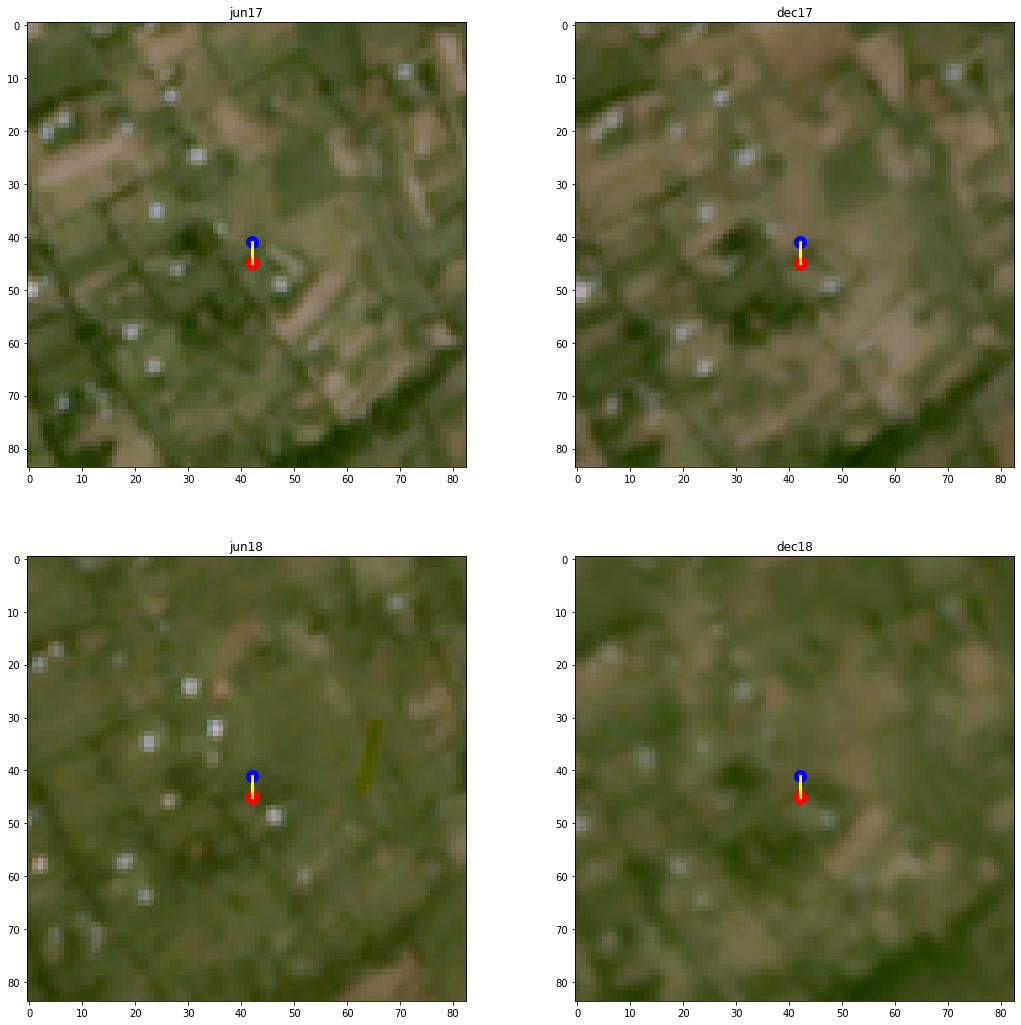

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))
#
ax[0][0].imshow(img_jun17); ax[0][0].set_title('jun17')
ax[0][0].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[0][0].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[0][0].scatter(x1, y1, marker='D', c='red', linewidth=7)
#
ax[0][1].imshow(img_dec17); ax[0][1].set_title('dec17')
ax[0][1].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[0][1].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[0][1].scatter(x1, y1, marker='D', c='red', linewidth=7)
#
ax[1][0].imshow(img_jun18); ax[1][0].set_title('jun18')
ax[1][0].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[1][0].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[1][0].scatter(x1, y1, marker='D', c='red', linewidth=7)
#
ax[1][1].imshow(img_dec18); ax[1][1].set_title('dec18')
ax[1][1].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[1][1].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[1][1].scatter(x1, y1, marker='D', c='red', linewidth=7)
plt.show()

Finally, we have the spectral band images.

We can see that the bands have different levels of detail.

In [19]:
def load_Spectral_image(ID):
  # e.g id_0b242e06 -> 0b242e06
  name = ID.split('_')[1]
  img_sentinel = skimage.io.imread(f'drive/MyDrive/data/sentinel/{name}.tif')
  return img_sentinel

In [20]:
img_sentinel = load_Spectral_image(row.ID.values[0])

Note that the image size can also slightly vary e.g. 41x41 or 41x40, similar to the RGB images.

It is important to account for this difference in your preprocessing code when training a model e.g. padding with zeros.

In [21]:
img_sentinel.shape

(41, 41, 112)

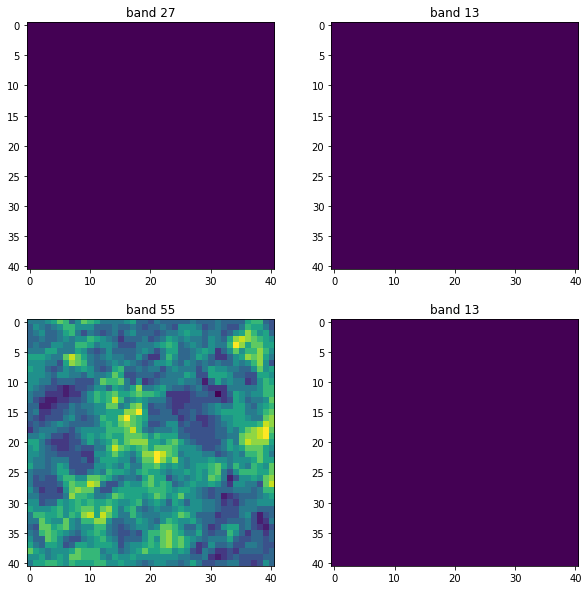

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
bands = np.random.randint(0, 192, size=4)
ax[0][0].imshow(img_sentinel[:,:,bands[0]])
ax[0][0].set_title(f'band {bands[0]}')
ax[0][1].imshow(img_sentinel[:,:,bands[1]])
ax[0][1].set_title(f'band {bands[1]}')
ax[1][0].imshow(img_sentinel[:,:,bands[2]])
ax[1][0].set_title(f'band {bands[2]}')
ax[1][1].imshow(img_sentinel[:,:,bands[3]])
ax[1][1].set_title(f'band {bands[3]}')
plt.show()

**AUXLIARY DATA**

In addition to the main training data, we also have additional data points in *auxilary_data.csv*.

These points can be used to improve the training of the model.

In [23]:
aux = pd.read_csv('drive/MyDrive/data/auxilary_data.csv')
aux.head(5)

,ID,Year,PlotSize_acres,Yield,Quality,x,y
0,id_92eb1b8c,2016,0.5,0.233750,3,0.351369,-0.010727
1,id_33a1e860,2016,0.5,0.233750,3,0.351369,-0.010727
2,id_93299277,2017,0.5,0.301875,3,0.717826,0.089839
3,id_1fd18958,2017,0.5,0.301875,3,0.717826,0.089839
4,id_d2c781e0,2017,0.5,0.301875,3,0.717826,0.089839


In [24]:
aux.Year.value_counts()

2016    998
2017    477
2018     15
Name: Year, dtype: int64

In [25]:
aux.Quality.value_counts()

1    587
3    463
2    440
Name: Quality, dtype: int64

In [26]:
aux.drop('Quality', 1).groupby("Year").describe(percentiles=[])

PlotSize_acres                      ...         y                    
              count      mean       std  ...       min       50%       max
Year                                     ...                              
2016          998.0  0.444925  0.321975  ... -0.539092 -0.049617  0.600811
2017          477.0  0.579717  0.541922  ... -0.852835 -0.033795  0.903867
2018           15.0  0.433333  0.253840  ... -0.580695 -0.024139  0.198476

[3 rows x 24 columns]

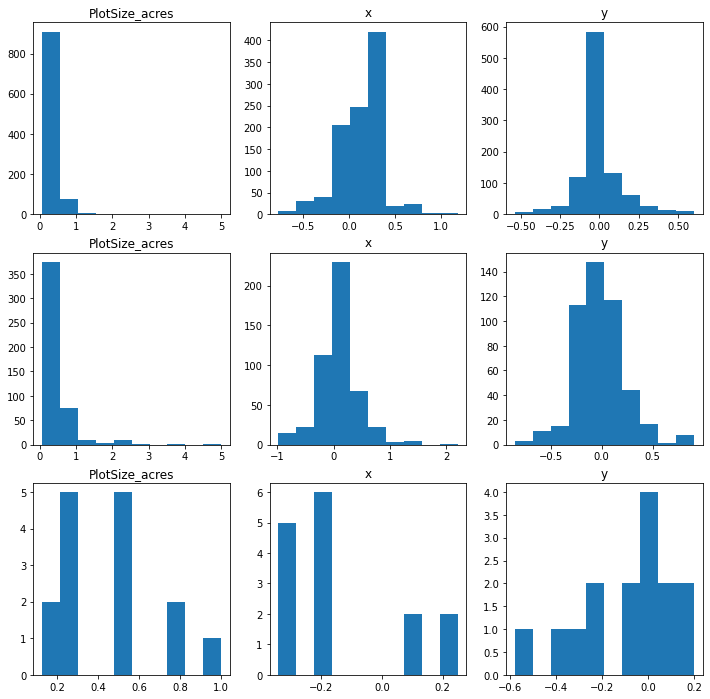

In [27]:
fig, ax = plt.subplots(len(aux.Year.unique()), 3, figsize=(12,12))
for i, year in enumerate(aux.Year.unique()):
  ax[i][0].hist(aux[aux.Year == year].PlotSize_acres)
  ax[i][0].set_title('PlotSize_acres')
  ax[i][1].hist(aux[aux.Year == year].x)
  ax[i][1].set_title('x')
  ax[i][2].hist(aux[aux.Year == year].y)
  ax[i][2].set_title('y')
plt.show()

Let's also visualize a sample from the auxilary data.

In [28]:
row = aux.sample()
row

,ID,Year,PlotSize_acres,Yield,Quality,x,y
250,id_ef36cc52,2016,5.0,0.26,3,-0.018775,-0.319182


In [29]:
img_jun17, img_dec17, img_jun18, img_dec18 = load_RGB_images(row.ID.values[0])

In [30]:
img_jun17.shape

(84, 84, 3)

In [31]:
x0, y0 = img_jun17.shape[1]//2, img_jun17.shape[1]//2
x1 = x0 - np.round(row.x.values[0] / CONST_X * img_jun17.shape[0])
y1 = y0 + np.round(row.y.values[0] / CONST_Y * img_jun17.shape[1])

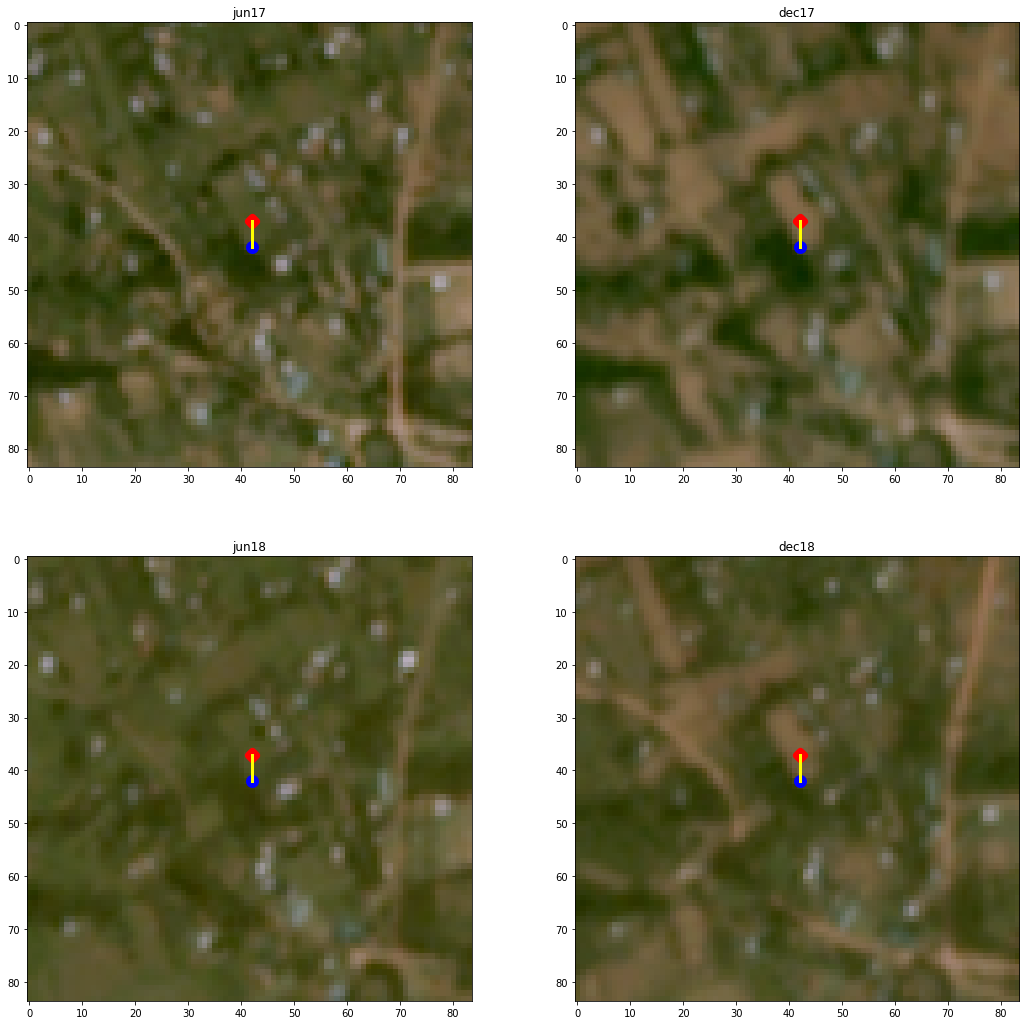

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))
#
ax[0][0].imshow(img_jun17); ax[0][0].set_title('jun17')
ax[0][0].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[0][0].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[0][0].scatter(x1, y1, marker='D', c='red', linewidth=7)
#
ax[0][1].imshow(img_dec17); ax[0][1].set_title('dec17')
ax[0][1].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[0][1].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[0][1].scatter(x1, y1, marker='D', c='red', linewidth=7)
#
ax[1][0].imshow(img_jun18); ax[1][0].set_title('jun18')
ax[1][0].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[1][0].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[1][0].scatter(x1, y1, marker='D', c='red', linewidth=7)
#
ax[1][1].imshow(img_dec18); ax[1][1].set_title('dec18')
ax[1][1].plot([x0, x1], [y0, y1], c='yellow', linewidth=3)
ax[1][1].scatter(x0, y0, marker='o', c='blue', linewidth=7)
ax[1][1].scatter(x1, y1, marker='D', c='red', linewidth=7)
plt.show()

In [33]:
img_sentinel = load_Spectral_image(row.ID.values[0])

In [34]:
img_sentinel.shape

(41, 41, 192)

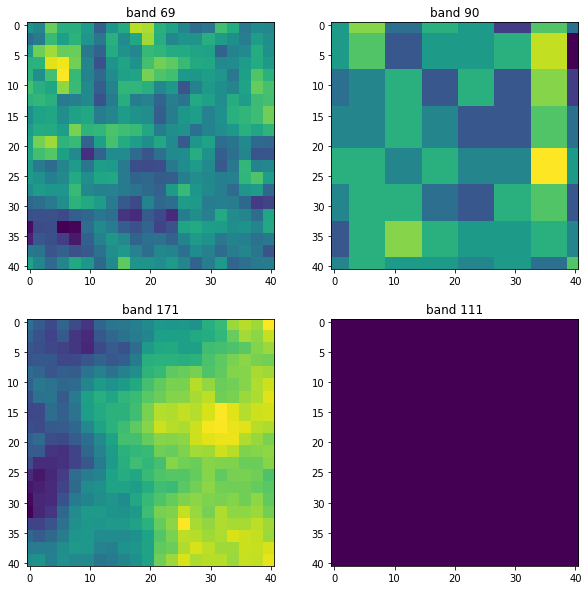

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
bands = np.random.randint(0, 192, size=4)
ax[0][0].imshow(img_sentinel[:,:,bands[0]])
ax[0][0].set_title(f'band {bands[0]}')
ax[0][1].imshow(img_sentinel[:,:,bands[1]])
ax[0][1].set_title(f'band {bands[1]}')
ax[1][0].imshow(img_sentinel[:,:,bands[2]])
ax[1][0].set_title(f'band {bands[2]}')
ax[1][1].imshow(img_sentinel[:,:,bands[3]])
ax[1][1].set_title(f'band {bands[3]}')
plt.show()

**TEST SET**

Now let's inspect the test data in *test.csv*. We will also visualize a sample but with out the markers.

The target columns (x, y) are not provided in *test.csv*. Note that the *Quality* column is also not provided.

In [36]:
test = pd.read_csv('drive/MyDrive/data/test.csv')
test.head(5)

,ID,Year,PlotSize_acres,Yield
0,id_e7032b10,2016,0.50,0.0
1,id_ae7cb51e,2018,1.00,NaN
2,id_e59f7730,2018,1.00,NaN
3,id_b9011c86,2018,1.50,NaN
4,id_caaeb9f8,2018,0.25,NaN


In [37]:
test.shape

(1613, 4)

In [38]:
row = test.sample()
row

,ID,Year,PlotSize_acres,Yield
956,id_dea59e93,2016,0.25,0.232


In [39]:
img_jun17, img_dec17, img_jun18, img_dec18 = load_RGB_images(row.ID.values[0])

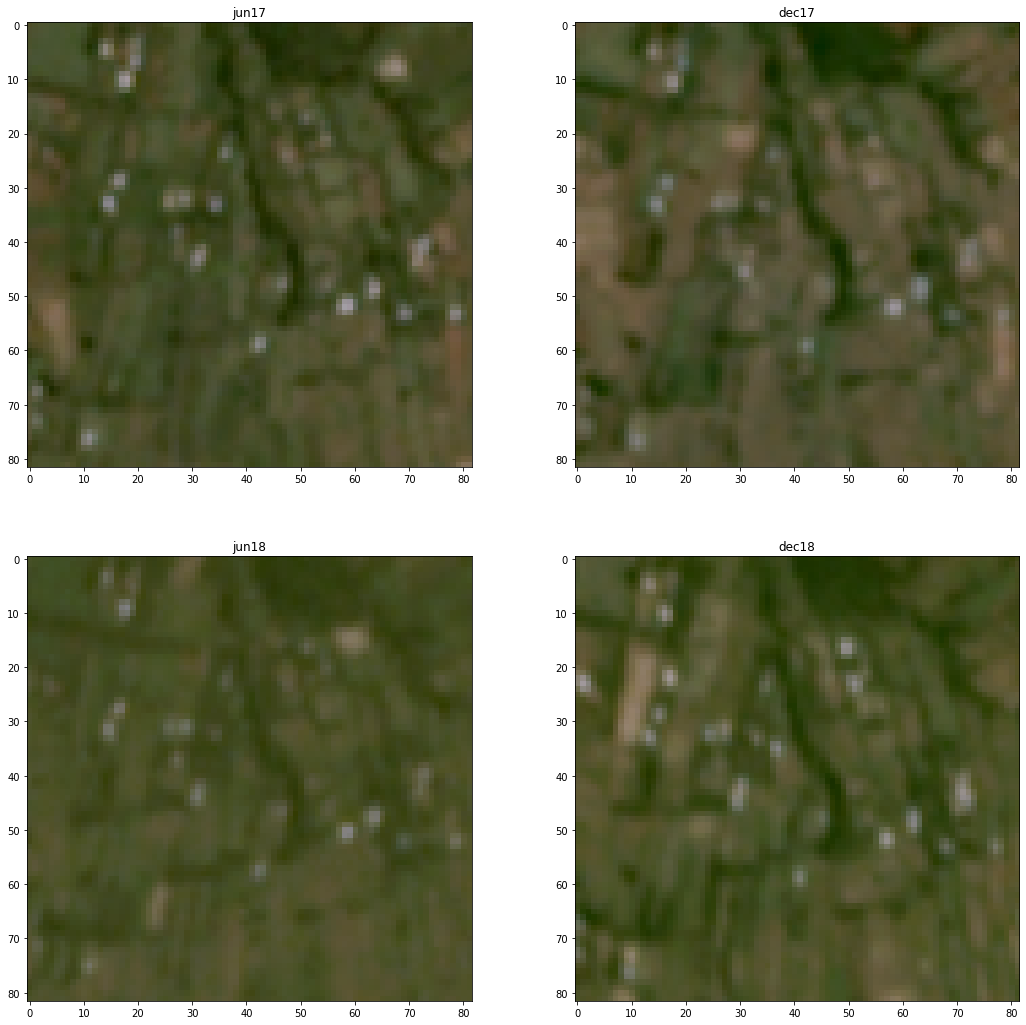

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))
#
ax[0][0].imshow(img_jun17); ax[0][0].set_title('jun17')
#
ax[0][1].imshow(img_dec17); ax[0][1].set_title('dec17')
#
ax[1][0].imshow(img_jun18); ax[1][0].set_title('jun18')
#
ax[1][1].imshow(img_dec18); ax[1][1].set_title('dec18')
plt.show()

In [41]:
img_sentinel = load_Spectral_image(row.ID.values[0])

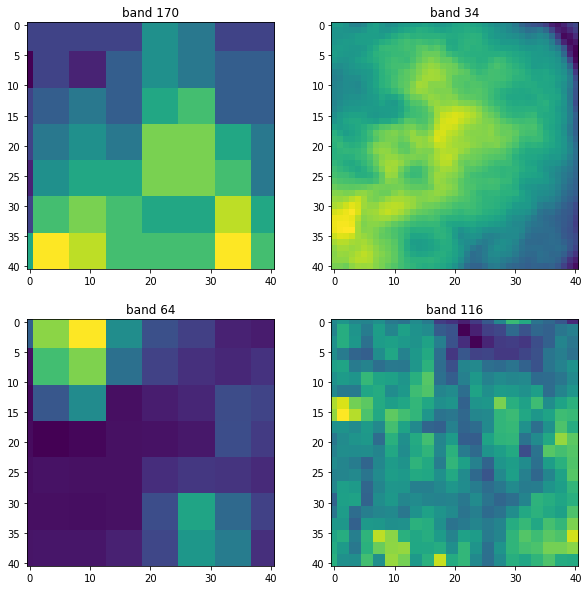

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
bands = np.random.randint(0, 192, size=4)
ax[0][0].imshow(img_sentinel[:,:,bands[0]])
ax[0][0].set_title(f'band {bands[0]}')
ax[0][1].imshow(img_sentinel[:,:,bands[1]])
ax[0][1].set_title(f'band {bands[1]}')
ax[1][0].imshow(img_sentinel[:,:,bands[2]])
ax[1][0].set_title(f'band {bands[2]}')
ax[1][1].imshow(img_sentinel[:,:,bands[3]])
ax[1][1].set_title(f'band {bands[3]}')
plt.show()

**SUBMISSION**

Now let's see how we can submit our predictions to be scored on the leaderboard.

The file *sample_submission.csv* has the IDs for the test images. This sample submission provides a baseline of zeros i.e. predicting the new point at the center of the image as the original point.

In [43]:
sample_submission = pd.read_csv('drive/MyDrive/data/sample_submission.csv')
sample_submission.head(5)

,ID,x,y
0,id_e7032b10,0.0,0.0
1,id_ae7cb51e,0.0,0.0
2,id_e59f7730,0.0,0.0
3,id_b9011c86,0.0,0.0
4,id_caaeb9f8,0.0,0.0


In [44]:
sample_submission.shape

(1613, 3)

Let's try making a new submission with the average values of (x, y) on the training data.

We evaluate the mean absolute error on the training data using the *scikit-learn* library. *Scikit-learn* also provides utilies to split the date with different validation schemes to estimate the unseen test error.

In [45]:
from sklearn.metrics import mean_absolute_error

In [46]:
mean_x = pd.concat([train, aux]).x.mean()
mean_y = pd.concat([train, aux]).y.mean()
mean_x, mean_y

(0.07505999551217189, -0.015081999598764427)

In [47]:
train['pred_x'] = mean_x
train['pred_y'] = mean_y

In [48]:
mean_absolute_error(train[['x', 'y']], train[['pred_x', 'pred_y']])

0.21259539317779297

Now let's make our predictions and write them in a csv file to be evaluated.

In [49]:
sample_submission['x'] = mean_x
sample_submission['y'] = mean_y

In [50]:
sample_submission.head(5)

,ID,x,y
0,id_e7032b10,0.07506,-0.015082
1,id_ae7cb51e,0.07506,-0.015082
2,id_e59f7730,0.07506,-0.015082
3,id_b9011c86,0.07506,-0.015082
4,id_caaeb9f8,0.07506,-0.015082


In [51]:
sample_submission.to_csv('drive/MyDrive/data/mean_submission.csv', index=False)